In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

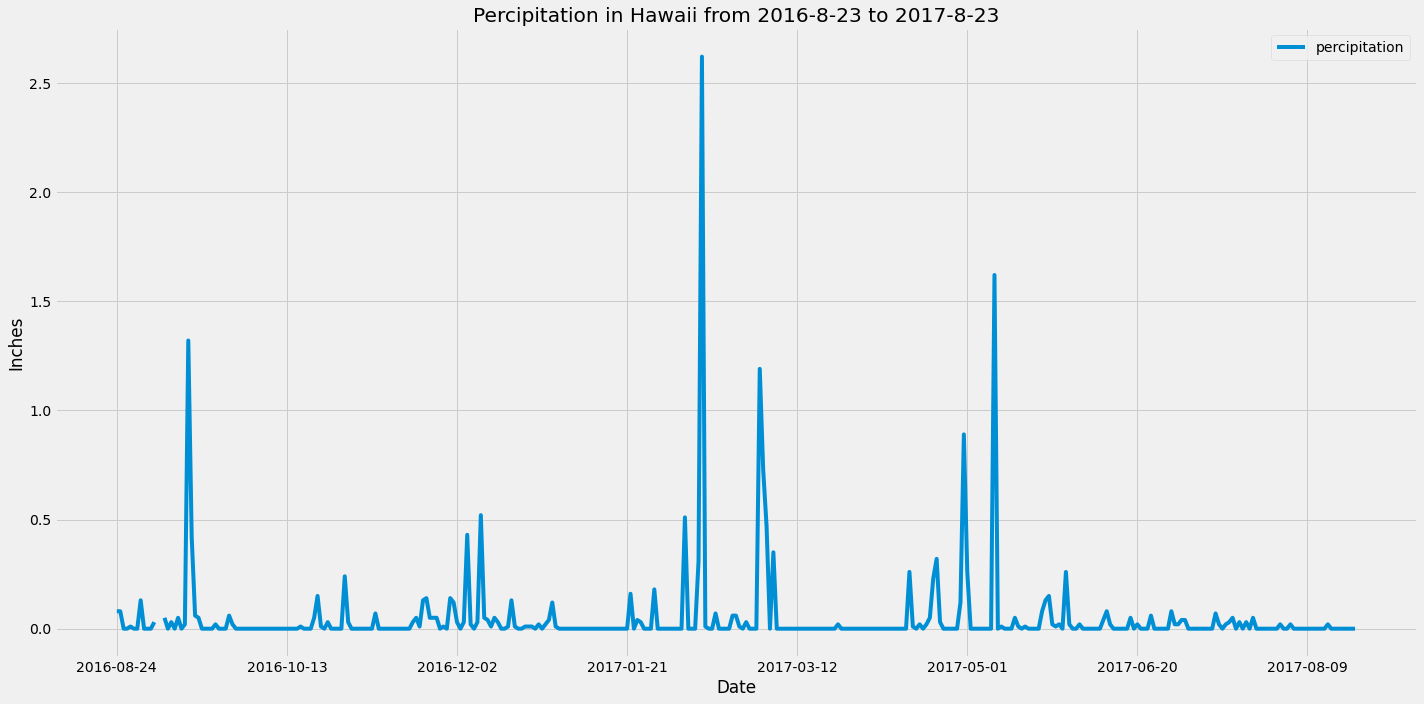

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores

twelve_date = dt.datetime(2016, 8, 23)

twelve_months = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= twelve_date).\
    group_by(measurement.date).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

twelve_df = pd.DataFrame(twelve_months, columns=['date','percipitation'])
twelve_df.set_index('date', inplace=True)
ax=twelve_df.plot(title="Percipitation in Hawaii from 2016-8-23 to 2017-8-23", figsize=(20,10))
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
plt.tight_layout()
plt.show()


In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
twelve_df.describe()

,percipitation
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [36]:
# Design a query to show how many stations are available in this dataset
session.query(station.station).count()

9

In [43]:
# What are the most active stations? (i.e. what stations have the most rows)
# List the stations and the counts in descending order.

session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station

session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

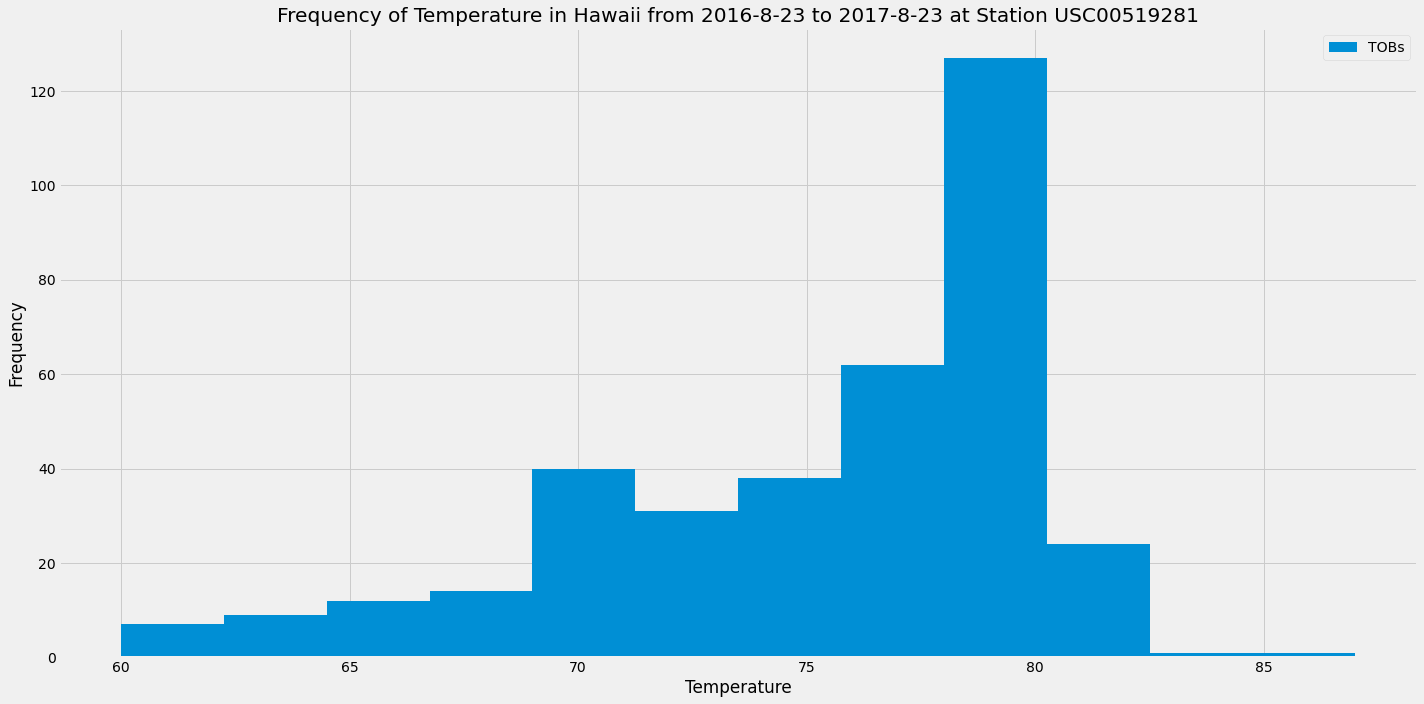

In [54]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

twelve_tobs = session.query(measurement.tobs).\
    filter(measurement.date > twelve_date).\
    group_by(measurement.date).\
    order_by(measurement.date).all()

twelve_tobs_df = pd.DataFrame(twelve_tobs, columns=['TOBs'])

ax=twelve_tobs_df.plot.hist(bins=12,title="Frequency of Temperature in Hawaii from 2016-8-23 to 2017-8-23 at Station USC00519281", figsize=(20,10))
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = (calc_temps('2017-07-01', '2017-07-10'))
print(my_trip)

[(69.0, 78.15254237288136, 87.0)]


C:\Users\vivie\anaconda3\envs\PythonData1\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


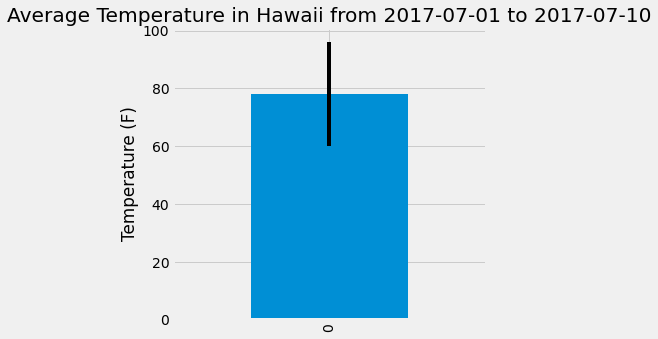

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip_df = pd.DataFrame(my_trip, columns=['Min Temp', 'Average Temp', 'Max Temp'])

avg_df = my_trip_df['Average Temp']
min_df = my_trip_df['Min Temp']
max_df = my_trip_df['Max Temp']

ax=avg_df.plot(kind='bar', yerr=[max_df - min_df],  figsize=(5,5), title="Average Temperature in Hawaii from 2017-07-01 to 2017-07-10")
ax.set_ylabel("Temperature (F)")
plt.tight_layout()
plt.show()

plt.show()

In [55]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [measurement.station, func.avg(measurement.prcp), station.latitude, station.longitude, station.elevation]
same_station = session.query(*sel).filter(measurement.station == station.station).\
                filter(measurement.date >= "2017-07-01").\
                filter(measurement.date <= "2017-07-10").\
                group_by(measurement.station).all()

same_station

[('USC00513117', 0.04, 21.4234, -157.8015, 14.6),
 ('USC00514830', 0.02, 21.5213, -157.8374, 7.0),
 ('USC00516128', 0.136, 21.3331, -157.8025, 152.4),
 ('USC00517948', None, 21.3934, -157.9751, 11.9),
 ('USC00519281', 0.077, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.012, 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0033333333333333335, 21.33556, -157.71139, 19.5)]

In [50]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [69]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates

start_date = "07-01"
end_date = "07-10"

# Stip off the year and save a list of %m-%d strings
date_list = ["07-01", "07-02", "07-03", "07-04", "07-05", "07-06", "07-07", "07-08", "07-09", "07-10"]
date_stats = []

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_list:
    date_stats.append(daily_normals(date))

date_stats[0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [62]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_stats_df = pd.DataFrame(date_stats, columns=['Min Percipitation', 'Average Percipitation', 'Max Percipitation'])
date_stats_df

ValueError: 3 columns passed, passed data had 1 columns

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
